# Load stuff up

In [1]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['axes.linewidth'] = 1.
matplotlib.rcParams['lines.linewidth'] = 2.5
matplotlib.rcParams['font.size'] = 15

import os
from astropy.io import fits

cmap='inferno'
matplotlib.rcParams['image.cmap'] = cmap


Populating the interactive namespace from numpy and matplotlib


In [2]:
hlc_psf_path = '/Users/mrizzo/IFS/OS6/'
haystacks_path = '/Users/mrizzo/IFS/crispy/crispy/Inputs/'
onaxis_psf_name = hlc_psf_path+'hlc_psf_onax.fits.gz'
offax_psf_fname = hlc_psf_path+'hlc_offax_psf_quad.fits'

output_path_detector = '/Users/mrizzo/IFS/OS6/Test_OS6/'
output_path_general  = '/Users/mrizzo/IFS/OS6/'

In [3]:
scene_imw = 71 
cx = scene_imw //2
pixscale_LoD = 0.4
pltscale_masec = 20.1

# Inspect inputs

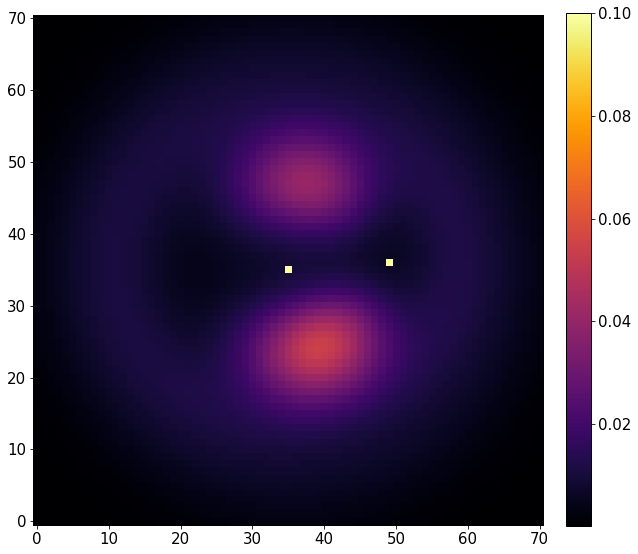

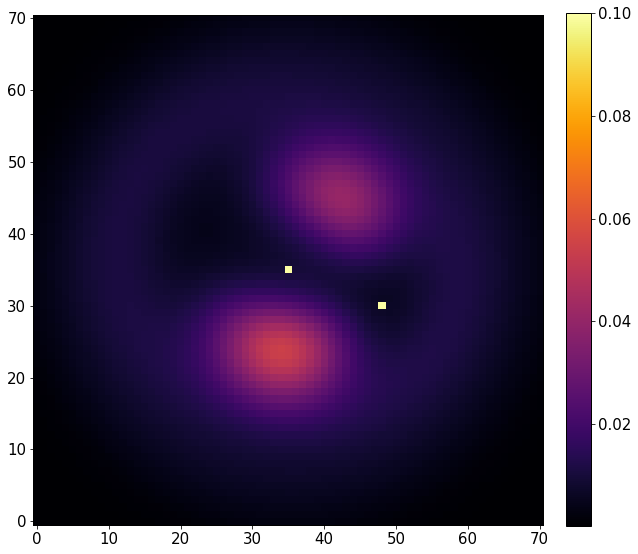

In [4]:
haystacks_fname = os.path.join(haystacks_path,'OS6n.fits.gz')
OS6n = fits.open(haystacks_fname)[0].data
# now the rotated map
haystacks_fname = os.path.join(haystacks_path,'OS6r.fits.gz')
OS6r = fits.open(haystacks_fname)[0].data

plt.figure(figsize=(10,10))
plt.imshow(OS6n,vmax=0.1)
plt.colorbar(fraction=0.046, pad=0.04)
plt.figure(figsize=(10,10))
plt.imshow(OS6r,vmax=0.1)
plt.colorbar(fraction=0.046, pad=0.04)


In [5]:
rescaled_data = fits.getdata(onaxis_psf_name)
psf_offax = fits.getdata(offax_psf_fname)

print rescaled_data.shape,psf_offax.shape

(3630, 71, 71) (1296, 71, 71)


# Convolve full map

In [6]:
from crispy.tools.cgi import xy_to_psf
haystacks_img_n = np.zeros_like(rescaled_data[0])
haystacks_img_r = np.zeros_like(rescaled_data[0])
for x in range(scene_imw):
    for y in range(scene_imw):
        if x != cx and y != cx:
            psf = np.nan_to_num(xy_to_psf(x, y, psf_offax))
            haystacks_img_n += OS6n[y, x] * psf
            haystacks_img_r += OS6r[y, x] * psf

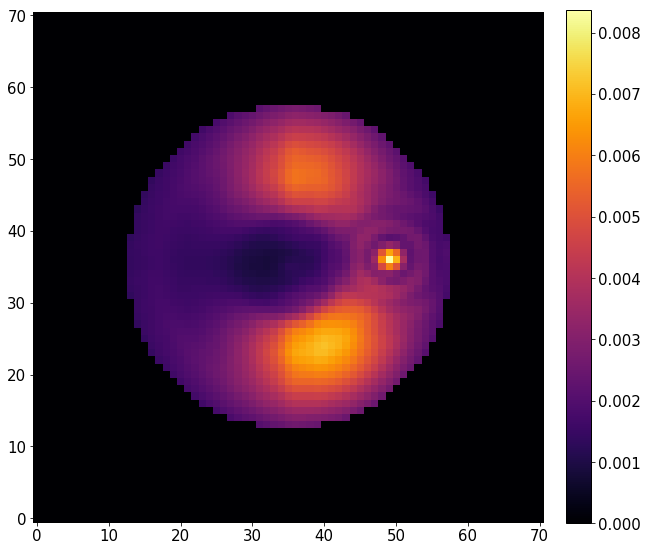

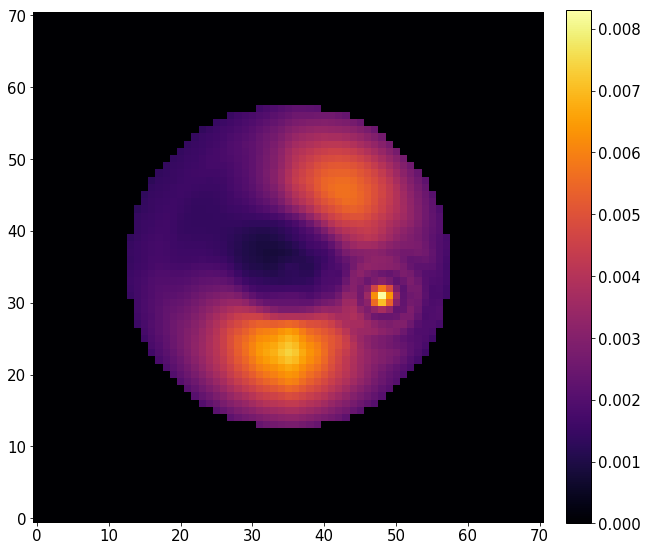

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(haystacks_img_n)
plt.colorbar(fraction=0.046, pad=0.04)
plt.figure(figsize=(10,10))
plt.imshow(haystacks_img_r)
plt.colorbar(fraction=0.046, pad=0.04)


# Load OS6 metadata

In [8]:
timesteps_fname = os.path.join(hlc_psf_path, 'timesteps.txt')
timesteps = np.loadtxt(timesteps_fname,skiprows=1)
startype = timesteps[:,0]
timestep = timesteps[:,1]
exptime = timesteps[:,2]
roll = timesteps[:,3]
flux = timesteps[:,4]

# Compute detector frames

In [9]:

crop = 75

from crispy.tools.detector import readoutPhotonFluxMapWFIRST_old as readoutWFIRST
exptime = 120. # this is the time corresponding to each frame from J. Krist
inttime_target = 60. # Time of individual frame for target
inttime_ref = 10. # time of individual frame for reference


for j in range(len(rescaled_data)):
    if j%100==0: print(j)
    img = rescaled_data[j]/exptime # convert to photons per second
    hdr = fits.PrimaryHDU().header
    hdr.append(('EXPTIME',exptime,'Total time on target for this file'),end=True)
    hdr.append(('STARTYPE',startype[j],'1 is reference, 2 is target'),end=True)
    hdr.append(('ROLL',roll[j],'1 or 3 is one roll, 2 or 4 is other roll'),end=True)

    if startype[j]==1: inttime = inttime_ref
    elif roll[j]==1 or roll[j]==3: 
        inttime = inttime_target
        img += haystacks_img_n
    else: 
        inttime = inttime_target
        img += haystacks_img_r
    hdr.append(('INTTIME',inttime,'Time per slice on target for this file'),end=True)
    
    # padding is especially important when modeling cosmic rays using Patrick's new code
    img = np.pad(img,pad_width=((crop,crop),(crop,crop)),mode='constant')
    
    EMGain = 4000.
#     crrate = 5.0
    lifefraction = 0.5
#     hprate = 3.0
    QE = 0.9
    RN = 100.
    CIC = 1e-2
    PCbias = 1000.
    pixscale = 0.4
    obs = readoutWFIRST(img,
                        tottime=exptime,
                        inttime=inttime,
                        PCcorrect=False, # don't correct for photon counting bias
                        PCmode = False, # activate photon-counting (PC) mode
                        EMGain= EMGain,
#                         crrate = crrate,
#                         hprate=hprate,
                        lifefraction=lifefraction,
#                         xs=300,ys=300,
                        QE = QE,
                        RN=RN,
                        CIC=CIC,
                        PCbias=PCbias
                        ).astype(np.int)
    hdr.append(('EMGAIN',EMGain,'EM Gain'),end=True)
    hdr.append(('QE',QE,'Base QE (before lifetime degradation)'),end=True)
    hdr.append(('LIFEFRAC',lifefraction,'Fraction of 5 year lifetime'),end=True)
#     hdr.append(('CRRATE',crrate,'Cosmic ray rate per second per cm2'),end=True)
#     hdr.append(('HPRATE',hprate,'Hot pixel rate'),end=True)
    hdr.append(('READN',RN,'Read noise (ct/pixel)'),end=True)
    hdr.append(('CIC',CIC,'Clock-induced charge (ct/pixel)'),end=True)
    hdr.append(('PCBIAS',PCbias,'Readout bias (already removed)'),end=True)
    hdr.append(('PIXSCALE',pixscale_LoD,'Pixel scale in lam/D'),end=True)
    hdr.append(('PLTSCALE',pltscale_masec,'Millarcsec/pixel'),end=True)

    fits.writeto(output_path_detector+'os6_%d.fits' % j, obs, header=hdr, overwrite=True)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600


# Average detector frames

In [10]:
Ndat_in_chunk = 55 # number of frames in a single chunk
datsize = timesteps.shape[0]
reference_chunks_ind = []
roll_plus_chunks_ind = []
roll_minus_chunks_ind = []
print datsize/Ndat_in_chunk

# cut into chunks
chunks_ind = np.split(np.arange(datsize),datsize/Ndat_in_chunk)

# assign chunks
for j in range(len(chunks_ind)):
    i = chunks_ind[j][0]
    if startype[i]==1: reference_chunks_ind.append(chunks_ind[j])
    # this is if you want to separate the two rolls
    elif roll[i]==1 or roll[i]==3: roll_minus_chunks_ind.append(chunks_ind[j])
    else: roll_plus_chunks_ind.append(chunks_ind[j])


print 'Summary:'
print 'There are %d reference chunks' % len(reference_chunks_ind)
print 'There are %d target chunks with minus 13deg roll' % len(roll_minus_chunks_ind)
print 'There are %d target chunks with plus 13deg roll' % len(roll_plus_chunks_ind)


reference_data_average = []
for j in range(len(reference_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(reference_chunks_ind[j])):
        ind = reference_chunks_ind[j][i]
        fname = output_path_detector+'os6_%d.fits' % ind
        hdu = fits.open(fname)
        obs = hdu[0].data
        hdu.close()
        chunk_indiv_frame.append(obs)
    arr = np.array(chunk_indiv_frame) #-np.mean(dark_ref,axis=0)[np.newaxis,np.newaxis,:,:]
    reference_data_average.append(np.nansum(np.nansum(arr,axis=0),axis=0)/np.prod(arr.shape[:2]))

roll_minus_data_average = []
for j in range(len(roll_minus_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(roll_minus_chunks_ind[j])):
        ind = roll_minus_chunks_ind[j][i]
        fname = output_path_detector+'os6_%d.fits' % ind
        hdu = fits.open(fname)
        obs = hdu[0].data
        hdu.close()
        chunk_indiv_frame.append(obs)
    arr = np.array(chunk_indiv_frame) #-np.mean(dark_target,axis=0)[np.newaxis,np.newaxis,:,:]
    roll_minus_data_average.append(np.nansum(np.nansum(arr,axis=0),axis=0)/np.prod(arr.shape[:2]))

roll_plus_data_average = []
for j in range(len(roll_plus_chunks_ind)):
    chunk_indiv_frame = []
    for i in range(len(roll_plus_chunks_ind[j])):
        ind = roll_plus_chunks_ind[j][i]
        fname = output_path_detector+'os6_%d.fits' % ind
        hdu = fits.open(fname)
        obs = hdu[0].data
        hdu.close()
        chunk_indiv_frame.append(obs)
    arr = np.array(chunk_indiv_frame) #-np.mean(dark_target,axis=0)[np.newaxis,np.newaxis,:,:]
    roll_plus_data_average.append(np.nansum(np.nansum(arr,axis=0),axis=0)/np.prod(arr.shape[:2]))


fits.writeto(output_path_general+'references_haystacks.fits',np.array(reference_data_average), overwrite=True)
fits.writeto(output_path_general+'roll_minus_haystacks.fits',np.array(roll_minus_data_average), overwrite=True)
fits.writeto(output_path_general+'roll_plus_haystacks.fits',np.array(roll_plus_data_average), overwrite=True)

print "Done"

66
Summary:
There are 14 reference chunks
There are 26 target chunks with minus 13deg roll
There are 26 target chunks with plus 13deg roll
Done


(14, 221, 221)


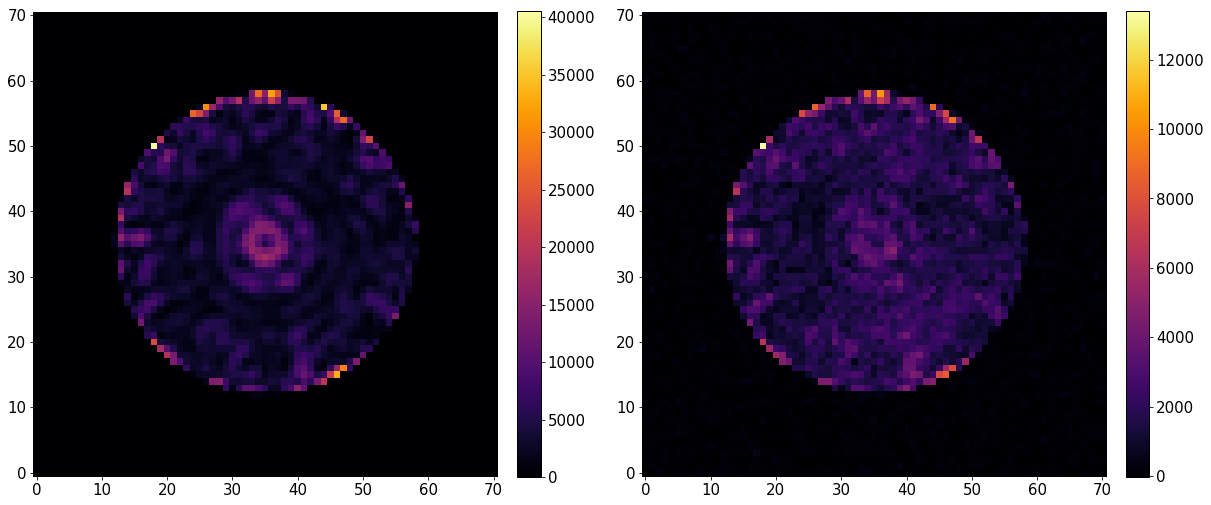

In [11]:
print np.array(reference_data_average).shape
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(np.array(reference_data_average)[0,crop:-crop,crop:-crop])
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(np.array(roll_minus_data_average)[0,crop:-crop,crop:-crop])
plt.colorbar(fraction=0.046, pad=0.04)


# Post-process

## Data mask

In [12]:
x_try = np.arange(scene_imw)
y_try = np.arange(scene_imw)

x_try, y_try = np.meshgrid(x_try, y_try)
xs_p = np.arange(scene_imw) - cx
ys_p = xs_p.copy()
xxs_p, yys_p = np.meshgrid(xs_p, ys_p)
rrs_p = np.sqrt(xxs_p**2 + yys_p**2)
data_select = np.logical_or(rrs_p >= 9. / pixscale_LoD,rrs_p <= 2.8 / pixscale_LoD)
data_mask = np.where(np.equal(~data_select, 1), 1, np.nan)


## Classical reference subtraction

In [13]:
from crispy.tools.postprocessing import vectorize_image_series,get_correlation_matrix,reconstruct_image_series
import scipy

ref_series = np.array(reference_data_average)[:,crop:-crop,crop:-crop]
target_roll_minus_series = np.array(roll_minus_data_average)[:,crop:-crop,crop:-crop]
target_roll_plus_series = np.array(roll_plus_data_average)[:,crop:-crop,crop:-crop]

ref_vec_series, data_ind, nan_ind, Np, Nexc = vectorize_image_series(ref_series, data_mask)
target_vec_minus_series, data_ind, nan_ind, Np, Nexc = vectorize_image_series(target_roll_minus_series, data_mask)
target_vec_plus_series, data_ind, nan_ind, Np, Nexc = vectorize_image_series(target_roll_plus_series, data_mask)

Nref = ref_series.shape[0]

## Use only one of the two roll orientations
all_vec_series = np.concatenate([ref_vec_series, target_vec_minus_series], axis=0)
target_series = target_roll_minus_series
target_vec_series = target_vec_minus_series

## Use both rolls as if they didn't exist
# target_series = np.concatenate([target_roll_minus_series, target_roll_plus_series], axis=0)
# target_vec_series = np.concatenate([target_vec_minus_series, target_vec_plus_series], axis=0)
# all_vec_series = np.concatenate([ref_vec_series, target_vec_minus_series, target_vec_plus_series], axis=0)


raw_corr_matx = get_correlation_matrix(all_vec_series)

peak_corr = np.max( raw_corr_matx[Nref:, :Nref], axis=1 )
peak_corr_ref_ind = np.argmax( raw_corr_matx[Nref:, :Nref], axis=1 )

# plt.figure(figsize=(10,10))
# plt.title('Data correlation')
# plt.imshow(raw_corr_matx,cmap=cmap)
# plt.colorbar(fraction=0.046, pad=0.04)

Ntarget = target_series.shape[0]

classicsub_s_cube = np.zeros((Ntarget, scene_imw, scene_imw))
classicsub_s_vec = np.zeros((Ntarget, Np))

for ii in range(Ntarget):
    # linear regression with reference star with highest correlation value
    b, a, _, _, _ = scipy.stats.linregress(ref_vec_series[ peak_corr_ref_ind[ii] ], target_vec_series[ii])
    classic_est_vec = a + b*ref_vec_series[ peak_corr_ref_ind[ii] ]
    classicsub_s_vec[ii] = target_vec_series[ii] - classic_est_vec
classicsub_s_cube = reconstruct_image_series(classicsub_s_vec, data_ind, nan_ind, scene_imw, scene_imw)


## Single 2-hour exposure stack

(-0.5, 70.5, -0.5, 70.5)

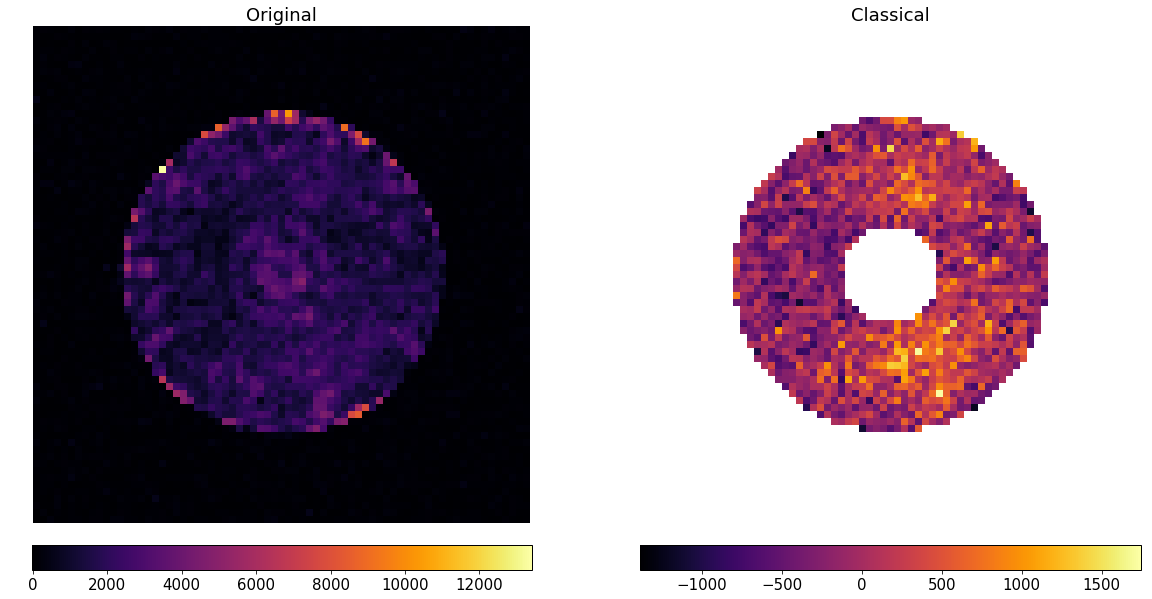

In [14]:
slice_select = 0

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title('Original')
plt.imshow(target_series[slice_select],cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.axis('off')
plt.subplot(122)
plt.title('Classical')
plt.imshow(classicsub_s_cube[slice_select],cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.axis('off')


## Average of all exposures

(-0.5, 70.5, -0.5, 70.5)

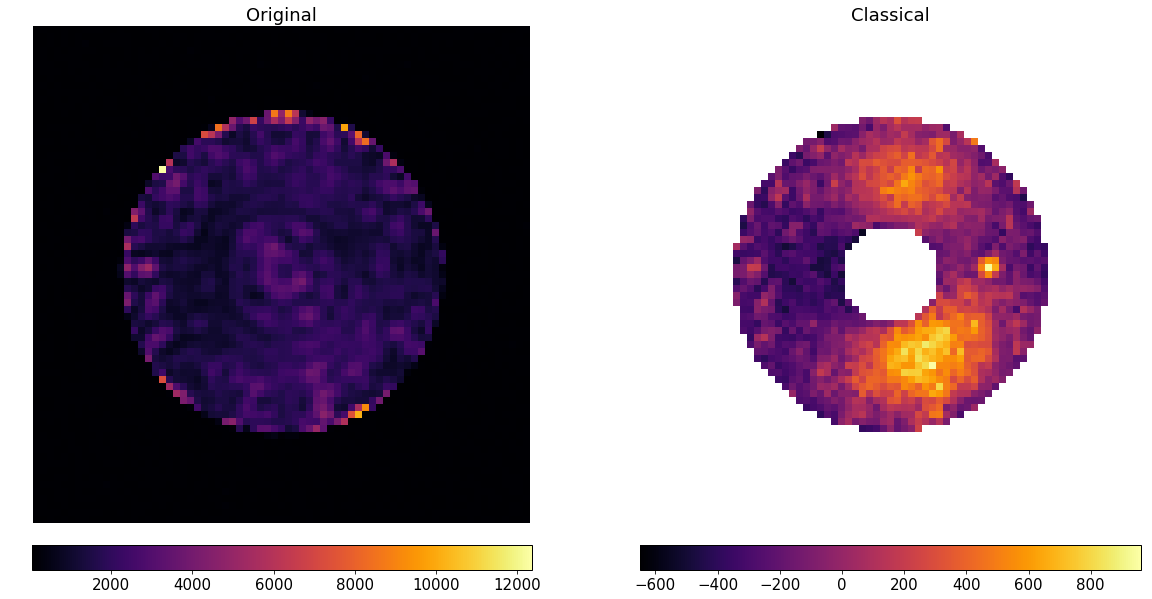

In [15]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title('Original')
plt.imshow(np.nanmean(target_series,axis=0),cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.axis('off')
plt.subplot(122)
plt.title('Classical')
plt.imshow(np.nanmean(classicsub_s_cube,axis=0),cmap=cmap)
plt.colorbar(orientation='horizontal',fraction=0.046, pad=0.04)
plt.axis('off')
